# NLP

Salman Hanif - 13523056

### Deskripsi Masalah
Diberi suatu dataset yang berisi 4.403 tweet dari Indonesia yang sudah diberi label lima jenis emosi :

1. Love
2. Anger
3. Sadness
4. Joy
5. Fear

### Data Format
Setiap baris terdiri dari sebuah twit dan label emosinya masing-masing yang dipisahkan oleh titik koma (,). Baris pertama adalah judul. Untuk twit dengan tanda koma (,) di dalam teks, terdapat tanda kutip (" ") untuk menghindari pemisahan kolom.
Tweet dalam kumpulan data ini telah diproses sebelumnya menggunakan kriteria berikut:
1. Penyebutan nama pengguna (@) telah diganti dengan istilah [USERNAME]
2. URL/hyperlink (http://... atau https://...) telah diganti dengan istilah [URL]
3. Nomor sensitif, seperti nomor telepon, nomor faktur, dan nomor pelacakan kurir telah diganti dengan istilah [SENSITIVE-NO]

### Pendekatan untuk menyelesaikan masalah
Saya akan menggunakan pretrained-model indoBERTweet yang merupakan model yang dilatih menggunakan tweet berbahasa indonesia dengan jumlah token sebanyak 409M yang diperoleh dari Twitter API, dari December 2019 hingga December 2020.

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Install required libraries

In [ ]:
 # %pip install plotly wandb transformers torch emoji

## Import Libraries

In [ ]:
# Standard Libraries
import random

# Data Science & Utilities
import numpy as np
import pandas as pd

# Text Processing
import emoji
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers (HuggingFace)
from transformers import AutoTokenizer, AutoModel

## Load Data

In [ ]:
DATA_PATHS = "/content/drive/MyDrive/Dataset/NLP_Classification_Twitter/Twitter_Emotion_Dataset.csv"
df = pd.read_csv(DATA_PATHS)

# Exploratory Data Analysis (EDA)

## 1. Analisis Distribusi Label


--- 1. Menganalisis Distribusi Label ---


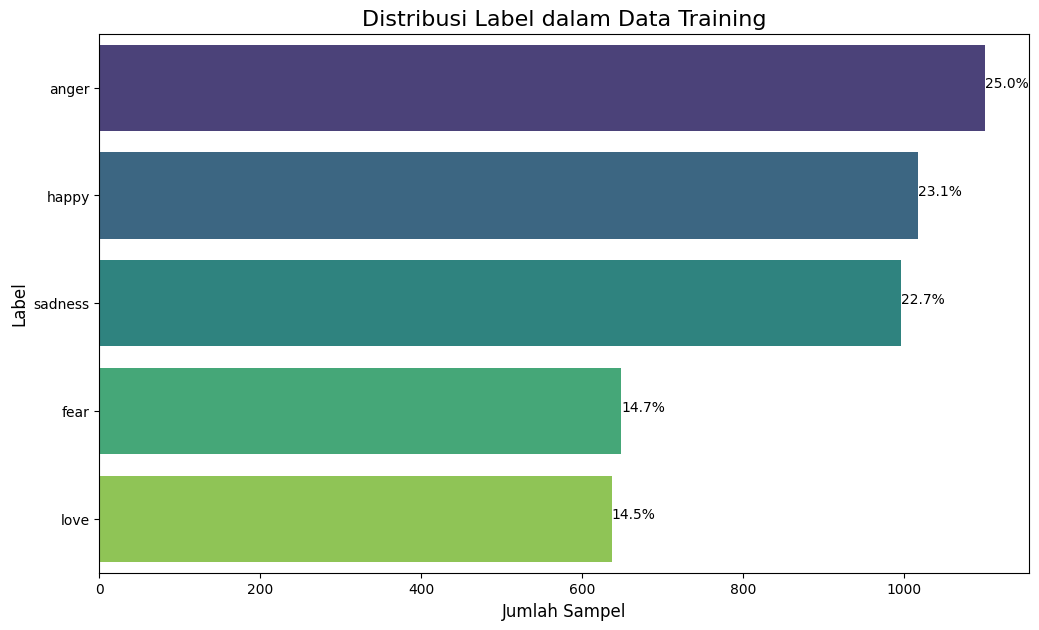

In [48]:
# --- 1. Analisis Distribusi Label ---
# Memahami sebaran setiap kelas sangat penting untuk mengetahui apakah dataset kita seimbang (balanced) atau tidak.
print("\n--- 1. Menganalisis Distribusi Label ---")
plt.figure(figsize=(12, 7))
ax = sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')

total = len(df['label'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.title('Distribusi Label dalam Data Training', fontsize=16)
plt.xlabel('Jumlah Sampel', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.show()

## 2. Analisis Panjang Teks


--- 2. Menganalisis Panjang Teks ---


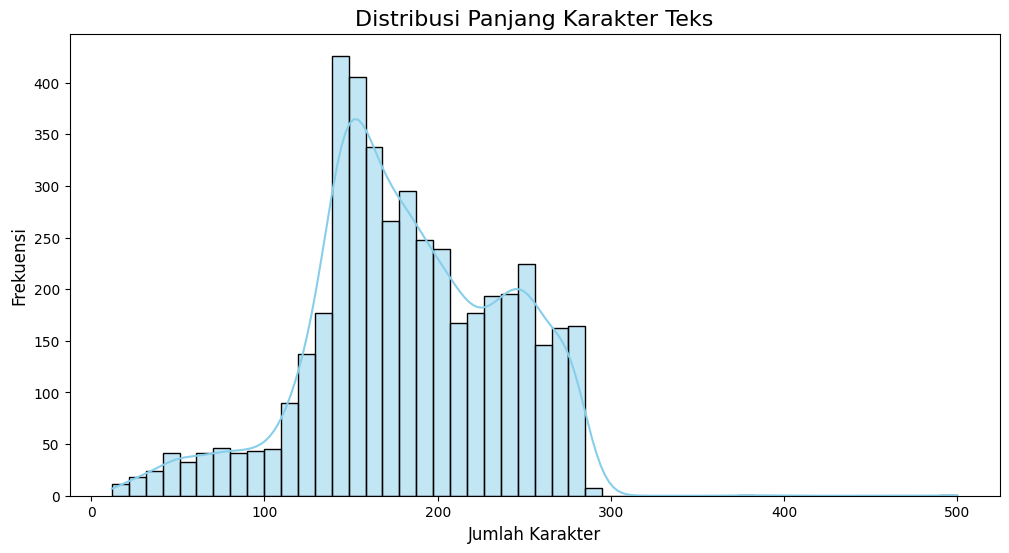

Statistik Panjang Karakter:
[count    4401.000000
mean      182.352193
std        55.697054
min        12.000000
25%       147.000000
50%       178.000000
75%       226.000000
max       500.000000
Name: char_length, dtype: float64]


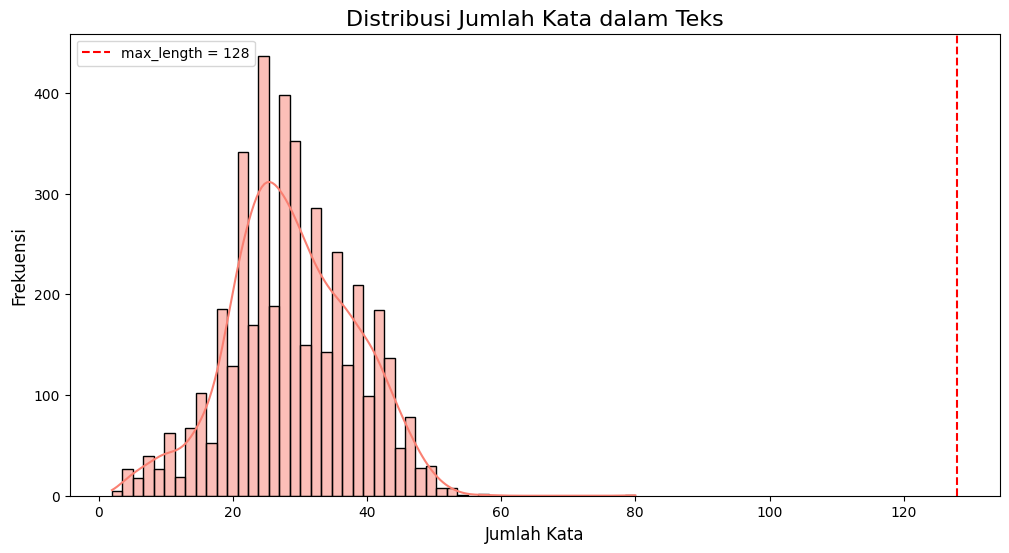


Statistik Jumlah Kata:
count    4401.000000
mean       28.783686
std         9.290808
min         2.000000
25%        23.000000
50%        28.000000
75%        35.000000
max        80.000000
Name: word_count, dtype: float64


In [49]:
# --- 2. Analisis Panjang Teks ---
# Menganalisis panjang teks membantu kita menentukan `max_length` yang optimal untuk tokenizer.
# Jika `max_length` terlalu pendek, informasi penting akan hilang.
# Jika terlalu panjang, pemborosan memori dan komputasi akan terjadi.
print("\n--- 2. Menganalisis Panjang Teks ---")

# Buat kolom baru untuk jumlah karakter dan jumlah kata
df['char_length'] = df['tweet'].str.len()
df['word_count'] = df['tweet'].str.split().apply(len)

# Plot distribusi jumlah karakter
plt.figure(figsize=(12, 6))
sns.histplot(df['char_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Panjang Karakter Teks', fontsize=16)
plt.xlabel('Jumlah Karakter', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.show()
print(f"Statistik Panjang Karakter:\n{[df['char_length'].describe()]}")


# Plot distribusi jumlah kata
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='salmon')
# Tambahkan garis vertikal untuk `max_length` yang Anda gunakan (128)
# Catatan: Ini adalah token, bukan kata, tapi bisa memberikan gambaran kasar
plt.axvline(x=128, color='red', linestyle='--', label='max_length = 128')
plt.title('Distribusi Jumlah Kata dalam Teks', fontsize=16)
plt.xlabel('Jumlah Kata', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.legend()
plt.show()
print(f"\nStatistik Jumlah Kata:\n{df['word_count'].describe()}")

## 3. Analisis N-grams (Kata & Frasa Paling Umum)


 3. Menganalisis Kata & Frasa Paling Umum 


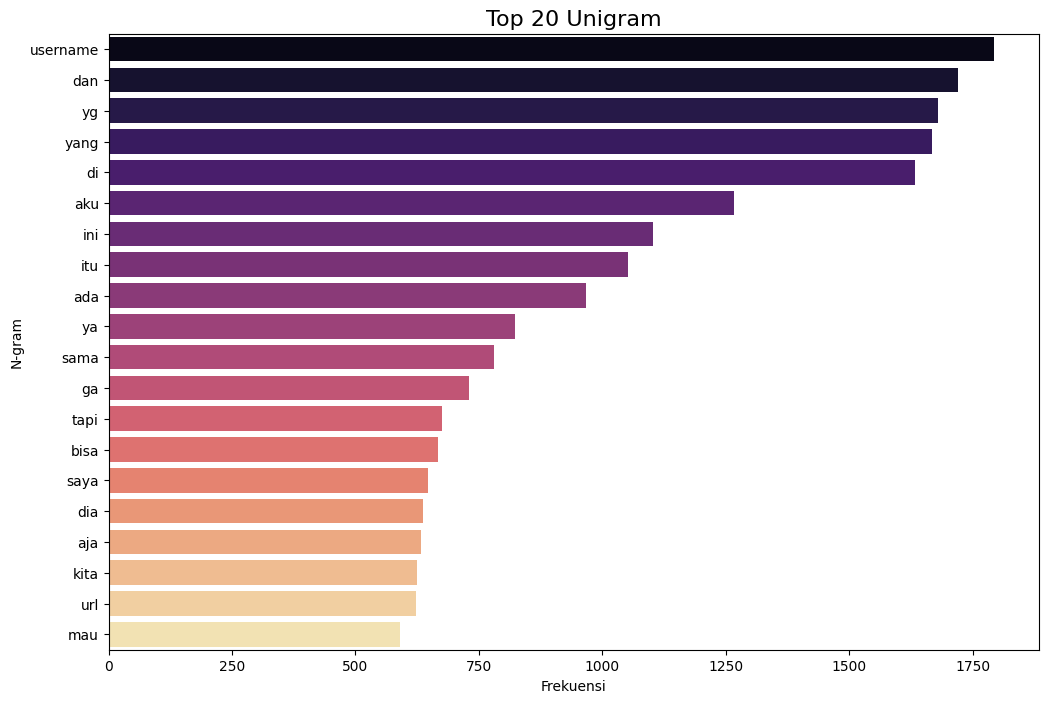

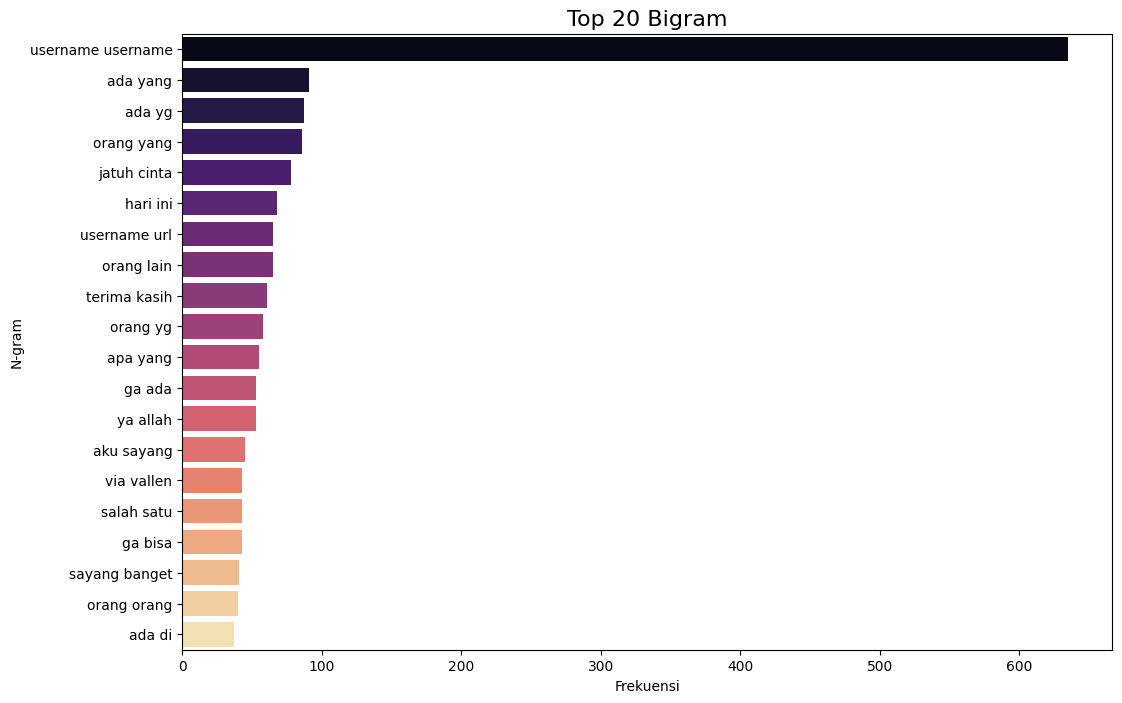

In [50]:
# --- 3. Analisis N-grams (Kata & Frasa Paling Umum) ---
# Ini membantu kita melihat kata atau frasa apa yang paling sering muncul,
# yang memberikan petunjuk tentang topik utama dalam dataset.

def plot_top_ngrams(corpus, n, gram_type='unigram'):
    """
    Fungsi untuk mem-plot n-gram yang paling umum.
    gram_type bisa 'unigram' (1 kata), 'bigram' (2 kata), dst.
    """
    if gram_type == 'unigram':
        ngram_range = (1, 1)
    elif gram_type == 'bigram':
        ngram_range = (2, 2)
    else:
        ngram_range = (3, 3)

    # Kita akan mengekstrak fitur n-gram dari teks
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Buat DataFrame untuk plotting
    top_df = pd.DataFrame(words_freq[:n], columns=['N-gram', 'Frekuensi'])

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frekuensi', y='N-gram', data=top_df, palette='magma')
    plt.title(f'Top {n} {gram_type.capitalize()}', fontsize=16)
    plt.show()

print("\n 3. Menganalisis Kata & Frasa Paling Umum ")
# Plot 20 kata paling umum (unigram)
plot_top_ngrams(df['tweet'], n=20, gram_type='unigram')

# Plot 20 frasa 2-kata paling umum (bigram)
plot_top_ngrams(df['tweet'], n=20, gram_type='bigram')

## 4. Word Cloud


--- 4. Membuat Word Cloud ---


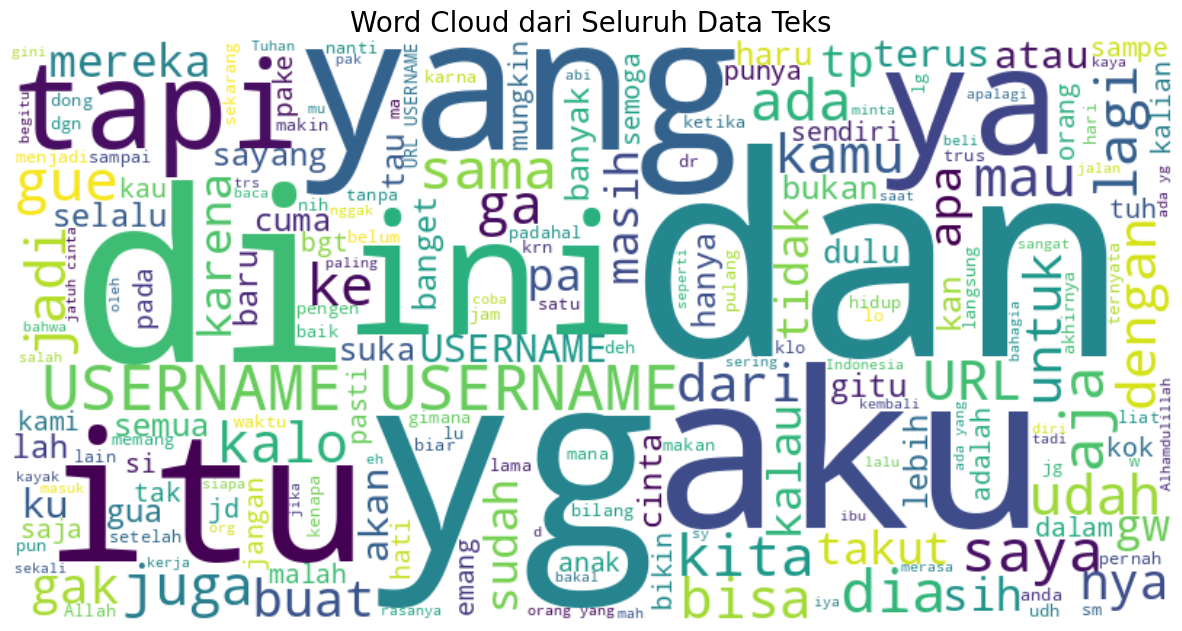

In [51]:
# --- 4. Word Cloud ---
# Word cloud memberikan visualisasi yang intuitif tentang kata-kata penting.
print("\n--- 4. Membuat Word Cloud ---")
all_text = ' '.join(df['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Seluruh Data Teks', fontsize=20)
plt.show()

## Data Preprocessing

### Pemangkasan teks
menghilangkan kata hasil transformasi dataset seperti [USERNAME], [SENSITIVE-NO]


 Hasil Pemangkasan : (Harusnya [USERNAME], [SENSITIVE-NO],[URL] sudah terhapus 


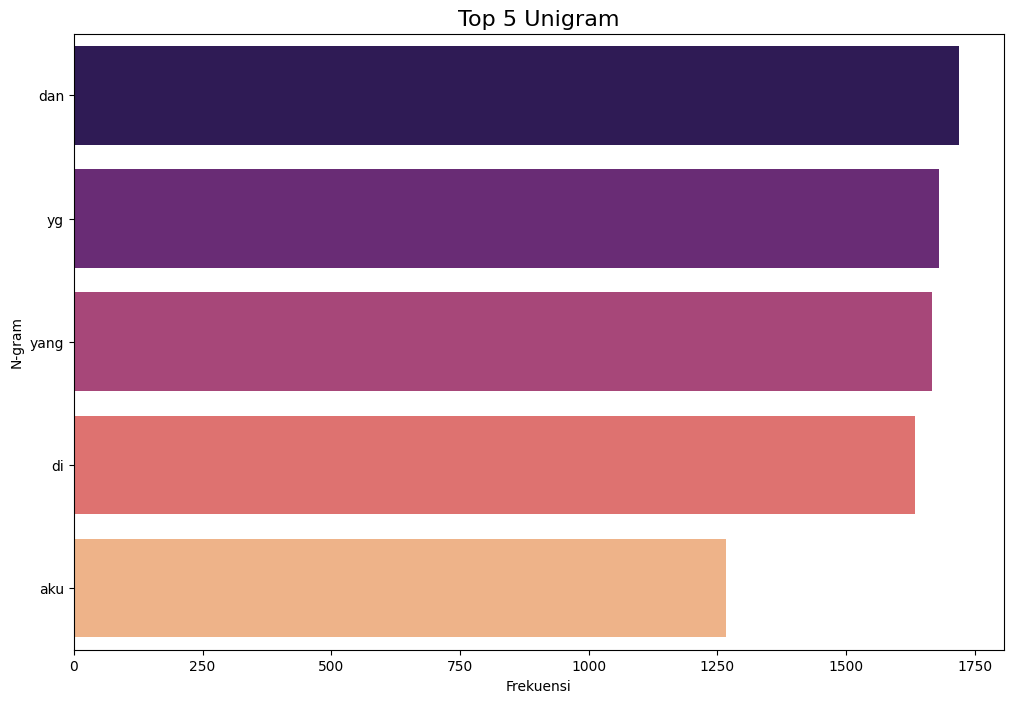

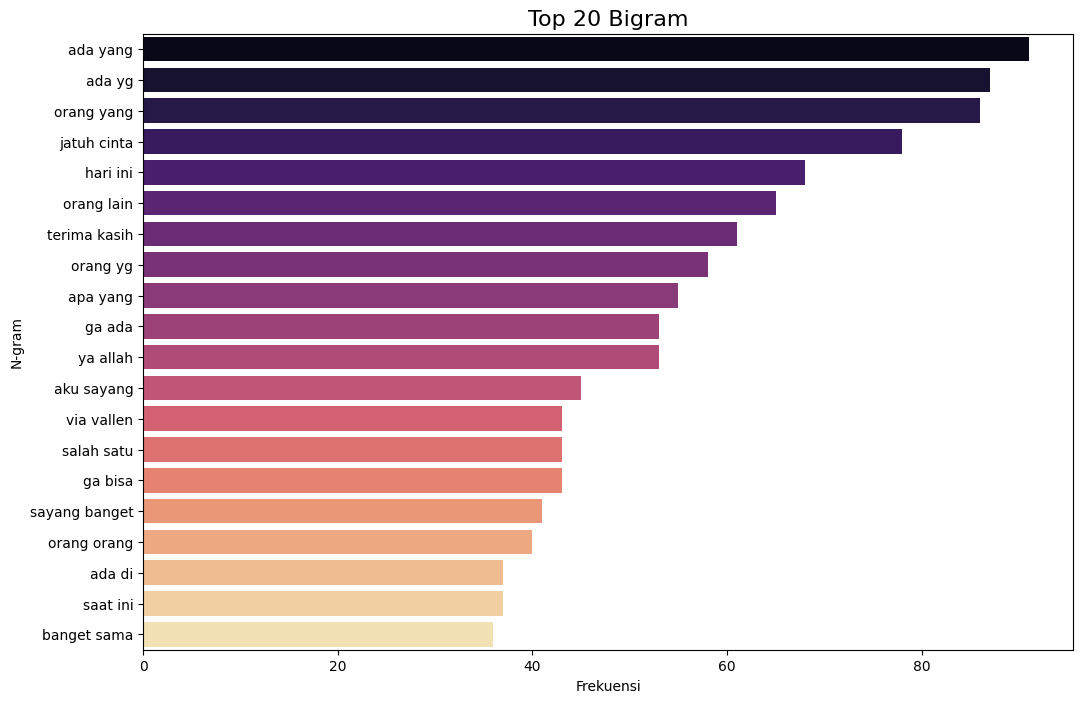

In [52]:
def clean_placeholders(text):
    return re.sub(r"\[USERNAME\]|\[URL\]|\[SENSITIVE-NO\]", "", text).strip()

# terapkan ke kolom tweet
df["clean_tweet"] = df["tweet"].apply(clean_placeholders)

print("\n Hasil Pemangkasan : (Harusnya [USERNAME], [SENSITIVE-NO],[URL] sudah terhapus ")
plot_top_ngrams(df['clean_tweet'], n=5, gram_type='unigram')
plot_top_ngrams(df['clean_tweet'], n=20, gram_type='bigram')

### Penyesuaian Text untuk Model IndoBertweet

In [53]:

def preprocess_text(text):
    '''
    Fungsi preproces text yang disesuaikan dengan rekomendasi developer IndoBERTweet
    1. Mengubah mention user menjadi @USER
    2. Mengubah url menjadi URL
    3. Mengubah emoji menjadi text menggunakan emoji.demojize
    '''
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"@\w+", "@USER", text)
    text = re.sub(r"http\S+|www\.\S+", "HTTPURL", text)
    text = emoji.demojize(text, delimiters=(":", ":"))

    return text

print('Preprocessing text data...')
df['indoBertweet_text'] = df['clean_tweet'].apply(preprocess_text)
print('Preprocessing complete.')

print(f'Train shape: {df.shape}')
df.head()

Preprocessing text data...
Preprocessing complete.
Train shape: (4401, 6)


,label,tweet,char_length,word_count,clean_tweet,indoBertweet_text
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",220,27,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","soal jln jatibaru,polisi tdk bs gertak gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",235,35,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,116,17,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj. amad foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",250,32,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","jln jatibaru,bagian dari wilayah tn abang.peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",203,30,"Sharing pengalaman aja, kemarin jam 18.00 bata...","sharing pengalaman aja, kemarin jam 18.00 bata..."


### Terjemahkan Singkatan ke Kata Aslinya berdasarkan Kamus

In [54]:
utility_df = pd.read_csv("/content/drive/MyDrive/Dataset/NLP_Classification_Twitter/kamus_singkatan.csv", sep=";")
utility_df.columns = utility_df.columns.str.strip()
utility_df["singkatan"] = utility_df["singkatan"].str.strip()
utility_df["kata_asli"] = utility_df["kata_asli"].str.strip()

# Buat dictionary singkatan -> kata_asli
singkatan_dict = dict(zip(utility_df["singkatan"], utility_df["kata_asli"]))

# Fungsi untuk mengganti kata di tweet
def ubah_singkatan(teks):
    return " ".join([singkatan_dict.get(kata, kata) for kata in teks.split()])

# Terapkan ke kolom tweet
df["prepro_text"] = df["indoBertweet_text"].astype(str).apply(ubah_singkatan)
df.head()

,label,tweet,char_length,word_count,clean_tweet,indoBertweet_text,prepro_text
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",220,27,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","soal jln jatibaru,polisi tdk bs gertak gubernu...","soal jalan jatibaru,polisi tidak bisa gertak g..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",235,35,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","sesama cewe lho (kayaknya), harusnya bisa lebi...","sesama cewek lho (kayaknya), harusnya bisa leb..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,116,17,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj. amad foto dari go...,ingin gudeg mbarek bu hj. amad foto dari googl...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",250,32,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","jln jatibaru,bagian dari wilayah tn abang.peng...","jalan jatibaru,bagian dari wilayah tn abang.pe..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",203,30,"Sharing pengalaman aja, kemarin jam 18.00 bata...","sharing pengalaman aja, kemarin jam 18.00 bata...","sharing pengalaman aja, kemarin jam 18.00 bata..."


## Persiapan Data untuk Training

### Label Encoding

In [55]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)
print(f'Number of classes: {num_classes}')

print('Classes:')
for i, cls in enumerate(le.classes_):
    print(f'{i+1}. {cls}')


n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=100)

Number of classes: 5
Classes:
1. anger
2. fear
3. happy
4. love
5. sadness


### Pemisahan Data Train dan Testing

In [56]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df[['label_encoded', 'prepro_text']], test_size=0.2, random_state=42)

print(train_df.shape, test_df.shape)
train_df.head()

(3520, 2) (881, 2)


,label_encoded,prepro_text
1769,4,"kaget dapat berita tetangga satu rt di solo, m..."
1220,4,tidak-enak sangat badanya ingin pulang tapi ke...
44,4,"oh iya, ibu nya ngelahirin anak ke 3 yaitu cew..."
289,2,"jiyeeee jiyeee, jeng domi abis menang lawan ke..."
2486,3,cinta penuh dengan banyak hal yang membuat sem...


## Model & Training

### Import model IndoBERTweet & Tokenisasi

In [57]:
from transformers import AutoTokenizer

# Ganti 'indolem/indobertweet-base-uncased' dengan nama model IndoBertweet yang spesifik
model_name = 'indolem/indobertweet-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Fungsi untuk tokenisasi
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Tokenisasi data latih dan uji
train_encodings = tokenize_function(train_df['prepro_text'].tolist())
test_encodings = tokenize_function(test_df['prepro_text'].tolist())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [58]:
import torch

class IndoBertweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Buat objek dataset
train_dataset = IndoBertweetDataset(train_encodings, train_df['label_encoded'].tolist())
test_dataset = IndoBertweetDataset(test_encodings, test_df['label_encoded'].tolist())

#### Helper for Evaluation

In [59]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix
import numpy as np

# Fungsi untuk menghitung metrik
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Menghitung metrik dasar
    acc = accuracy_score(labels, predictions)
    balanced_acc = balanced_accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Menghitung confusion matrix (dalam bentuk numpy array)
    conf_matrix = confusion_matrix(labels, predictions)

    return {
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix.tolist() # Ubah ke list agar bisa dicetak
    }

## The Actual Training

In [60]:
# %pip install tf-keras

In [80]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model_name = 'indolem/indobertweet-base-uncased'
num_labels = len(train_df['label_encoded'].unique())
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Jalankan pelatihan
print("Memulai pelatihan...")
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Memulai pelatihan...


Step,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall,Confusion Matrix
100,1.514700,1.414718,0.438138,0.407850,0.430695,0.608233,0.438138,"[[83, 1, 8, 3, 134], [9, 8, 3, 2, 97], [2, 3, 88, 17, 104], [2, 0, 12, 48, 57], [6, 0, 16, 19, 159]]"
200,0.830200,0.757276,0.725312,0.709415,0.720538,0.727149,0.725312,"[[209, 1, 3, 0, 16], [21, 71, 5, 1, 21], [7, 1, 163, 18, 25], [3, 1, 16, 87, 12], [42, 9, 29, 11, 109]]"
300,0.536300,0.653739,0.760499,0.752755,0.759380,0.762826,0.760499,"[[205, 4, 2, 0, 18], [15, 86, 3, 1, 14], [11, 3, 159, 18, 23], [4, 2, 11, 89, 13], [33, 14, 14, 8, 131]]"
400,0.598900,0.659404,0.763905,0.767465,0.764739,0.769032,0.763905,"[[179, 4, 5, 2, 39], [9, 87, 4, 1, 18], [3, 3, 176, 15, 17], [0, 2, 11, 102, 4], [14, 10, 30, 17, 129]]"
500,0.236800,0.827709,0.761635,0.769985,0.760624,0.765903,0.761635,"[[183, 9, 9, 6, 22], [7, 93, 5, 1, 13], [3, 3, 172, 24, 12], [0, 2, 9, 103, 5], [17, 12, 30, 21, 120]]"
600,0.386500,0.720160,0.778661,0.774943,0.779805,0.785813,0.778661,"[[195, 2, 1, 2, 29], [12, 84, 2, 1, 20], [7, 0, 167, 19, 21], [0, 1, 11, 99, 8], [24, 6, 20, 9, 141]]"


Trainer is attempting to log a value of "[[83, 1, 8, 3, 134], [9, 8, 3, 2, 97], [2, 3, 88, 17, 104], [2, 0, 12, 48, 57], [6, 0, 16, 19, 159]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[209, 1, 3, 0, 16], [21, 71, 5, 1, 21], [7, 1, 163, 18, 25], [3, 1, 16, 87, 12], [42, 9, 29, 11, 109]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[205, 4, 2, 0, 18], [15, 86, 3, 1, 14], [11, 3, 159, 18, 23], [4, 2, 11, 89, 13], [33, 14, 14, 8, 131]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[179, 4, 5, 2, 39], [9, 87, 4,

Step,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall,Confusion Matrix
100,1.514700,1.414718,0.438138,0.407850,0.430695,0.608233,0.438138,"[[83, 1, 8, 3, 134], [9, 8, 3, 2, 97], [2, 3, 88, 17, 104], [2, 0, 12, 48, 57], [6, 0, 16, 19, 159]]"
200,0.830200,0.757276,0.725312,0.709415,0.720538,0.727149,0.725312,"[[209, 1, 3, 0, 16], [21, 71, 5, 1, 21], [7, 1, 163, 18, 25], [3, 1, 16, 87, 12], [42, 9, 29, 11, 109]]"
300,0.536300,0.653739,0.760499,0.752755,0.759380,0.762826,0.760499,"[[205, 4, 2, 0, 18], [15, 86, 3, 1, 14], [11, 3, 159, 18, 23], [4, 2, 11, 89, 13], [33, 14, 14, 8, 131]]"
400,0.598900,0.659404,0.763905,0.767465,0.764739,0.769032,0.763905,"[[179, 4, 5, 2, 39], [9, 87, 4, 1, 18], [3, 3, 176, 15, 17], [0, 2, 11, 102, 4], [14, 10, 30, 17, 129]]"
500,0.236800,0.827709,0.761635,0.769985,0.760624,0.765903,0.761635,"[[183, 9, 9, 6, 22], [7, 93, 5, 1, 13], [3, 3, 172, 24, 12], [0, 2, 9, 103, 5], [17, 12, 30, 21, 120]]"
600,0.386500,0.720160,0.778661,0.774943,0.779805,0.785813,0.778661,"[[195, 2, 1, 2, 29], [12, 84, 2, 1, 20], [7, 0, 167, 19, 21], [0, 1, 11, 99, 8], [24, 6, 20, 9, 141]]"


TrainOutput(global_step=660, training_loss=0.7320881561799483, metrics={'train_runtime': 242.4694, 'train_samples_per_second': 43.552, 'train_steps_per_second': 2.722, 'total_flos': 651217402598400.0, 'train_loss': 0.7320881561799483, 'epoch': 3.0})

## Evaluation

#### Evaluating Visualization Functions


Memulai evaluasi...


Trainer is attempting to log a value of "[[188, 4, 1, 1, 35], [8, 89, 2, 1, 19], [5, 0, 172, 18, 19], [0, 1, 13, 97, 8], [20, 8, 24, 9, 139]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Hasil evaluasi:
 {'eval_loss': 0.7048261761665344, 'eval_accuracy': 0.7775255391600454, 'eval_balanced_accuracy': 0.7765448453061998, 'eval_f1': 0.779347799789999, 'eval_precision': 0.7834689582085904, 'eval_recall': 0.7775255391600454, 'eval_confusion_matrix': [[188, 4, 1, 1, 35], [8, 89, 2, 1, 19], [5, 0, 172, 18, 19], [0, 1, 13, 97, 8], [20, 8, 24, 9, 139]], 'eval_runtime': 4.106, 'eval_samples_per_second': 214.563, 'eval_steps_per_second': 3.41, 'epoch': 3.0}

Confusion Matrix:
 [[188   4   1   1  35]
 [  8  89   2   1  19]
 [  5   0 172  18  19]
 [  0   1  13  97   8]
 [ 20   8  24   9 139]]


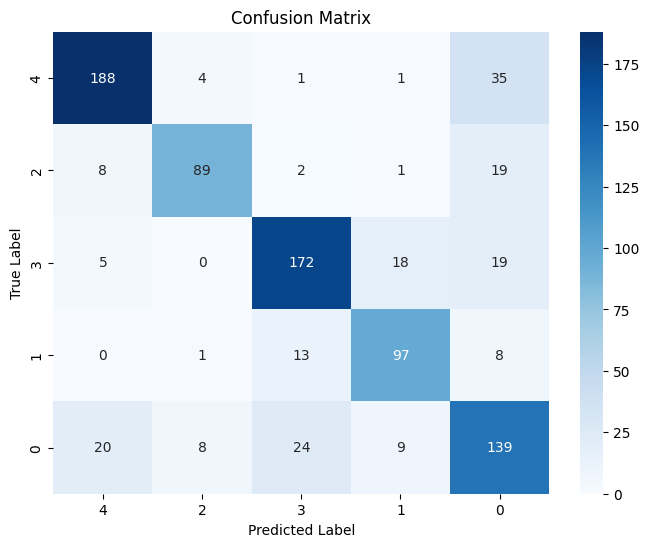

In [81]:
# Jalankan evaluasi
print("\nMemulai evaluasi...")
evaluation_results = trainer.evaluate()
print("Hasil evaluasi:\n", evaluation_results)

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Hitung dan plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:\n", cm)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_df['label_encoded'].unique(), yticklabels=train_df['label_encoded'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### K-Fold

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, balanced_accuracy_score
import torch

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = []
all_true_labels = []
all_predicted_labels = []

for fold, (train_index, test_index) in enumerate(kf.split(df)):
    print(f"\n===== Memulai Fold {fold + 1}/{n_splits} =====")

    # Memisahkan data untuk fold saat ini
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    # Tokenisasi data untuk fold saat ini
    tokenizer = AutoTokenizer.from_pretrained('indolem/indobertweet-base-uncased')
    train_encodings = tokenizer(train_df['prepro_text'].tolist(), padding=True, truncation=True, return_tensors='pt')
    test_encodings = tokenizer(test_df['prepro_text'].tolist(), padding=True, truncation=True, return_tensors='pt')

    # Buat dataset PyTorch
    train_dataset = IndoBertweetDataset(train_encodings, train_df['label_encoded'].tolist())
    test_dataset = IndoBertweetDataset(test_encodings, test_df['label_encoded'].tolist())

    # Muat model baru untuk setiap fold
    model = AutoModelForSequenceClassification.from_pretrained('indolem/indobertweet-base-uncased',
                                                             num_labels=len(df['label_encoded'].unique()))

    # Tentukan argumen pelatihan
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold + 1}',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    # Inisialisasi Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Latih model
    trainer.train()
    evaluation_results = trainer.evaluate()
    fold_results.append(evaluation_results)

    # Lakukan prediksi untuk mendapatkan true dan predicted labels
    predictions_fold = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions_fold.predictions, axis=1)
    true_labels = predictions_fold.label_ids

    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)


===== Memulai Fold 1/5 =====


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall,Confusion Matrix
1,0.822000,0.722077,0.749149,0.748598,0.742652,0.755411,0.749149,"[[200, 3, 8, 3, 15], [21, 80, 9, 1, 8], [6, 0, 173, 26, 9], [1, 2, 10, 104, 2], [30, 8, 39, 20, 103]]"
2,0.602100,0.616686,0.794552,0.788620,0.792255,0.795203,0.794552,"[[208, 5, 1, 1, 14], [17, 89, 2, 1, 10], [7, 4, 178, 7, 18], [4, 2, 12, 97, 4], [37, 12, 16, 7, 128]]"
3,0.261000,0.763946,0.774120,0.767689,0.776641,0.783984,0.774120,"[[190, 5, 3, 2, 29], [8, 84, 3, 2, 22], [6, 1, 164, 16, 27], [1, 1, 12, 93, 12], [14, 9, 20, 6, 151]]"


Trainer is attempting to log a value of "[[200, 3, 8, 3, 15], [21, 80, 9, 1, 8], [6, 0, 173, 26, 9], [1, 2, 10, 104, 2], [30, 8, 39, 20, 103]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[208, 5, 1, 1, 14], [17, 89, 2, 1, 10], [7, 4, 178, 7, 18], [4, 2, 12, 97, 4], [37, 12, 16, 7, 128]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[190, 5, 3, 2, 29], [8, 84, 3, 2, 22], [6, 1, 164, 16, 27], [1, 1, 12, 93, 12], [14, 9, 20, 6, 151]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[[208, 5, 1, 1, 14], [17, 89, 2, 1, 10], [7, 4, 178, 7, 18], [4, 2, 12, 97, 4], [37, 12, 16, 7, 128]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.



===== Memulai Fold 2/5 =====


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall,Confusion Matrix
1,0.801200,0.776487,0.723864,0.730475,0.732217,0.763487,0.723864,"[[147, 3, 10, 0, 61], [3, 100, 3, 2, 26], [6, 4, 132, 10, 44], [0, 1, 15, 107, 14], [14, 4, 12, 11, 151]]"
2,0.602700,0.619367,0.778409,0.783745,0.778358,0.779088,0.778409,"[[180, 8, 4, 3, 26], [6, 106, 3, 2, 17], [10, 6, 149, 11, 20], [0, 2, 12, 120, 3], [22, 9, 18, 13, 130]]"
3,0.312300,0.670359,0.789773,0.796719,0.789719,0.790624,0.789773,"[[173, 11, 8, 0, 29], [6, 109, 5, 2, 12], [8, 5, 157, 12, 14], [0, 2, 11, 121, 3], [17, 10, 20, 10, 135]]"


Trainer is attempting to log a value of "[[147, 3, 10, 0, 61], [3, 100, 3, 2, 26], [6, 4, 132, 10, 44], [0, 1, 15, 107, 14], [14, 4, 12, 11, 151]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[180, 8, 4, 3, 26], [6, 106, 3, 2, 17], [10, 6, 149, 11, 20], [0, 2, 12, 120, 3], [22, 9, 18, 13, 130]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[173, 11, 8, 0, 29], [6, 109, 5, 2, 12], [8, 5, 157, 12, 14], [0, 2, 11, 121, 3], [17, 10, 20, 10, 135]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [85]:
# Cetak hasil rata-rata dari semua folds
print("\n===== Hasil Rata-rata dari Semua Folds =====")
avg_acc = np.mean([res['eval_accuracy'] for res in fold_results])
avg_balanced_acc = np.mean([res['eval_balanced_accuracy'] for res in fold_results])
avg_f1 = np.mean([res['eval_f1'] for res in fold_results])

print(f"Rata-rata Akurasi: {avg_acc:.4f}")
print(f"Rata-rata Balanced Accuracy: {avg_balanced_acc:.4f}")
print(f"Rata-rata F1-Score: {avg_f1:.4f}")

# Cetak confusion matrix untuk semua fold secara gabungan
cm_total = confusion_matrix(all_true_labels, all_predicted_labels)
print("\n===== Confusion Matrix Keseluruhan =====")
print(cm_total)


===== Hasil Rata-rata dari Semua Folds =====
Rata-rata Akurasi: 0.7787
Rata-rata Balanced Accuracy: 0.7772
Rata-rata F1-Score: 0.7782

===== Confusion Matrix Keseluruhan =====
[[939  22  25   8 107]
 [ 56 479  12   9  93]
 [ 45  16 795  54 107]
 [  6   7  74 528  22]
 [139  32  95  45 686]]
